# Assignment 4: Wheres Waldo?
### Name: Eileanor LaRocco
In this assignment, you will develop an object detection algorithm to locate Waldo in a set of images. You will develop a model to detect the bounding box around Waldo. Your final task is to submit your predictions on Kaggle for evaluation.

### Process/Issues
- Double-checked that the images we were given were correctly bounded (did this by visualizing the boxes on the images - they look good!)
- Complication: Originally when I creating augmented images, the bounding box labels did not also augment. I also had to try out a few types of augmentation to see what made sense for waldo. The augmented images may still not be as different from one another as they could be which could allow the model to favor the training images that occur more frequently.
- Complication: Similarly, when resizing the images, ensuring the bounding boxes not only are also adjusted if necessary, but ensuring they do not get cut off and the image is not stretched/shrunk too much.
- Tried Yolo architecture first but produced too many boxes and did not work well. Tried faster rcnn architecture next and the inputs and outputs and processing steps for each were very different which was frustrating

### Imports

In [1]:
import os
import opendatasets as od
import pandas as pd
import numpy as np
import random
import csv
import matplotlib.pyplot as plt

import shutil
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data
from torch.utils.data import DataLoader
import torchvision
import torch.nn.functional as F
import torchvision.transforms as transforms
from PIL import Image

In [8]:
SEED = 1

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

device = device = torch.device("mps") #mps/cuda
print(device)

mps


### Paths

In [20]:
train_folder = "2024-fall-ml-3-hw-4-wheres-waldo/train/train" # Original Train Images
test_folder = "2024-fall-ml-3-hw-4-wheres-waldo/test/test" # Original Test Images
annotations_file = "2024-fall-ml-3-hw-4-wheres-waldo/annotations.csv" # Original Annotations File
image_sz = 512

In [21]:
# Define the dataset (Train and Test Loaders)
class WaldoDataset(torch.utils.data.Dataset):
    def __init__(self, annotations_file, img_dir, transforms=None):
        self.img_labels = pd.read_csv(annotations_file)
        self.img_dir = img_dir
        self.transforms = transforms

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
        image = Image.open(img_path).convert("RGB")
        #image = torchvision.transforms.ToTensor()(image)  # Convert to tensor
        
        box_data = self.img_labels.iloc[idx, 1:].values
        boxes = [float(item) for item in box_data]
        
        boxes = torch.as_tensor([boxes], dtype=torch.float32)
        labels = torch.ones((1,), dtype=torch.int64)
        image_id = torch.tensor([idx])
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        iscrowd = torch.zeros((1,), dtype=torch.int64)
        
        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["image_id"] = image_id
        target["area"] = area
        target["iscrowd"] = iscrowd

        if self.transforms is not None:
            image = self.transforms(image)

        return image, target


# Set up the dataset and data loaders
train_dataset = WaldoDataset(
    annotations_file="2024-fall-ml-3-hw-4-wheres-waldo/train_annotations.csv",
    img_dir="2024-fall-ml-3-hw-4-wheres-waldo/train/chunks",
    transforms=torchvision.transforms.Compose([
        torchvision.transforms.Resize((image_sz, image_sz)), #does this resize the bounding box too?
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])
)

val_dataset = WaldoDataset(
    annotations_file="2024-fall-ml-3-hw-4-wheres-waldo/test_annotations.csv",
    img_dir="2024-fall-ml-3-hw-4-wheres-waldo/train/val",
    transforms=torchvision.transforms.Compose([
        torchvision.transforms.Resize((image_sz, image_sz)),
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])
)

train_data_loader = DataLoader(
    train_dataset,
    batch_size=16,
    shuffle=True,
    collate_fn=lambda x: list(zip(*x))  # Fix the collate_fn to return a list of images and targets
)

val_data_loader = DataLoader(
    val_dataset,
    batch_size=16,
    shuffle=False,
    collate_fn=lambda x: list(zip(*x))  # Same here for validation
)


# Model

### Architecture

In [34]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class SimpleRCNN(nn.Module):
    def __init__(self):
        super(SimpleRCNN, self).__init__()
        
        # Backbone: Feature extraction using convolutional layers
        self.backbone = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1),  # Conv layer 1
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(2),  # Downsample to 256x256
            
            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),  # Conv layer 2
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2),  # Downsample to 128x128
            
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),  # Conv layer 3
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2),  # Downsample to 64x64
        )
        
        # Region Proposal Network (RPN): Proposes bounding boxes
        self.rpn = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),  # RPN Conv layer
            nn.ReLU(),
            nn.Conv2d(128, 9 * 4, kernel_size=1),  # 9 anchors, each with 4 bbox coords
        )
        
        # Fully connected layers for bounding box refinement
        self.fc1 = nn.Linear(64 * 7 * 7, 256)  # RoI pooled feature size
        self.fc2 = nn.Linear(256, 4)  # Outputs bounding box coords (x, y, w, h)
        
    def forward(self, x):
        # Step 1: Extract features using the backbone
        features = self.backbone(x)
        
        # Step 2: Generate region proposals with RPN
        rpn_out = self.rpn(features)  # RPN outputs raw bounding box coordinates
        
        # For simplicity, let's assume we have a fixed number of RoIs from RPN
        # In practice, RoIs are obtained using Non-Maximum Suppression (NMS)
        # Here we simulate RoI pooling on a fixed region
        roi = features[:, :, :7, :7]  # Simulate RoI extraction (64x7x7)
        
        # Step 3: Flatten the RoI features for fully connected layers
        roi_flattened = roi.reshape(roi.size(0), -1)  # Use reshape instead of view
        
        # Step 4: Predict bounding boxes
        x = F.relu(self.fc1(roi_flattened))
        bbox = self.fc2(x)
        
        return bbox


# Instantiate the model
model = SimpleRCNN()

# Test the model with a random input tensor of size (batch_size=1, channels=3, height=512, width=512)
input_tensor = torch.randn(1, 3, 512, 512)  # Example input
output = model(input_tensor)

print("Predicted Bounding Box:", output)


Predicted Bounding Box: tensor([[ 0.0606,  0.0118, -0.2076, -0.5215]], grad_fn=<AddmmBackward0>)


### Training

In [33]:
def calculate_iou(pred_boxes, target_boxes):
    """
    Compute IoU between predicted and target bounding boxes.
    Args:
        pred_boxes: Tensor of shape (N, 4) with predicted boxes (x_min, y_min, x_max, y_max).
        target_boxes: Tensor of shape (N, 4) with ground truth boxes (x_min, y_min, x_max, y_max).
    Returns:
        IoU: Tensor of shape (N,) with IoU scores for each box.
    """
    # Resize Target Boxes
    target_boxes = target_boxes.squeeze(1)

    # Calculate intersection
    x_min_inter = torch.max(pred_boxes[:, 0], target_boxes[:, 0])
    y_min_inter = torch.max(pred_boxes[:, 1], target_boxes[:, 1])
    x_max_inter = torch.min(pred_boxes[:, 2], target_boxes[:, 2])
    y_max_inter = torch.min(pred_boxes[:, 3], target_boxes[:, 3])

    inter_area = torch.clamp(x_max_inter - x_min_inter, min=0) * torch.clamp(y_max_inter - y_min_inter, min=0)

    # Calculate union
    pred_area = (pred_boxes[:, 2] - pred_boxes[:, 0]) * (pred_boxes[:, 3] - pred_boxes[:, 1])
    target_area = (target_boxes[:, 2] - target_boxes[:, 0]) * (target_boxes[:, 3] - target_boxes[:, 1])
    union_area = pred_area + target_area - inter_area

    # Compute IoU
    iou = inter_area / torch.clamp(union_area, min=1e-6)  # Avoid division by zero
    return iou


def train(model, train_data_loader, criterion, optimizer):
    model.train()
    running_loss = 0.0
    total_iou = 0.0
    num_samples = 0

    for images, targets in train_data_loader:
        
        images = [img.to(device) for img in images]
        targets = [{k: v.to(device) for k, v in target.items()} for target in targets]
        
        # Extract bounding boxes from targets
        target_boxes = torch.stack([target["boxes"] for target in targets]).squeeze(1)

        # Forward pass
        optimizer.zero_grad()
        outputs = model(torch.stack(images))

        # Calculate the loss
        loss = criterion(outputs, target_boxes)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        # Update running loss
        running_loss += loss.item()

        # Calculate IoU
        iou = calculate_iou(outputs, target_boxes)
        total_iou += iou.sum().item()
        num_samples += len(target_boxes)

    avg_loss = running_loss / len(train_data_loader)
    avg_iou = total_iou / num_samples

    print(f"Training Loss: {avg_loss:.4f}, IoU: {avg_iou:.4f}")


def evaluate(model, val_data_loader, criterion):
    model.eval()
    total_loss = 0.0
    total_iou = 0.0
    num_samples = 0

    with torch.no_grad():
        for images, targets in val_data_loader:
            
            images = [img.to(device) for img in images]
            targets = [{k: v.to(device) for k, v in target.items()} for target in targets]
            
            # Extract bounding boxes from targets
            target_boxes = torch.stack([target["boxes"] for target in targets]).squeeze(1)

            # Forward pass
            outputs = model(torch.stack(images))

            # Calculate the loss
            loss = criterion(outputs, target_boxes)
            total_loss += loss.item()

            # Calculate IoU
            iou = calculate_iou(outputs, target_boxes)
            total_iou += iou.sum().item()
            num_samples += len(target_boxes)

    avg_loss = total_loss / len(val_data_loader)
    avg_iou = total_iou / num_samples

    print(f"Evaluation Loss: {avg_loss:.4f}, IoU: {avg_iou:.4f}")
    
    
# Set up the model, loss, and optimizer
model = SimpleModel().to(device)
criterion = nn.L1Loss()  # L1 loss for bounding box regression
optimizer = optim.Adam(model.parameters(), lr=0.001)
num_epochs = 20

for epoch in range(num_epochs):
    print(f"Epoch {epoch + 1}/{num_epochs}")
    
    # Train the model
    train(model, train_data_loader, criterion, optimizer)

    # Evaluate the model
    evaluate(model, val_data_loader, criterion)



Epoch 1/20
Training Loss: 136.0130, IoU: 0.0015
Evaluation Loss: 133.5285, IoU: 0.0031
Epoch 2/20
Training Loss: 123.3413, IoU: 0.0014
Evaluation Loss: 129.9587, IoU: 0.0048
Epoch 3/20
Training Loss: 121.1447, IoU: 0.0022
Evaluation Loss: 132.3211, IoU: 0.0027
Epoch 4/20
Training Loss: 114.9201, IoU: 0.0015
Evaluation Loss: 124.8544, IoU: 0.0051
Epoch 5/20
Training Loss: 108.3784, IoU: 0.0018
Evaluation Loss: 135.3724, IoU: 0.0009
Epoch 6/20
Training Loss: 107.4784, IoU: 0.0028
Evaluation Loss: 135.1595, IoU: 0.0000
Epoch 7/20
Training Loss: 97.9234, IoU: 0.0050
Evaluation Loss: 147.7733, IoU: 0.0001
Epoch 8/20
Training Loss: 90.1473, IoU: 0.0053
Evaluation Loss: 143.9005, IoU: 0.0000
Epoch 9/20


KeyboardInterrupt: 

# Submission File 

Predicted Bounding Box: [181.39006 173.33951 235.77457 208.99481]


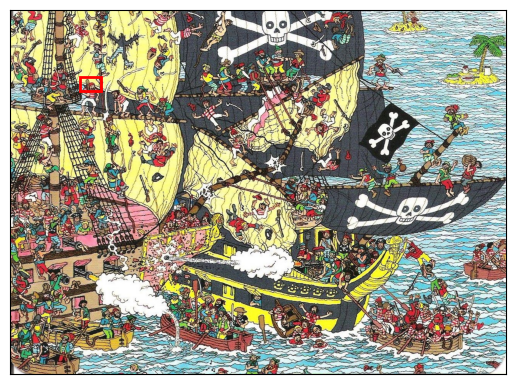

Predicted Bounding Box: [115.697044 110.19301  150.85359  133.58408 ]


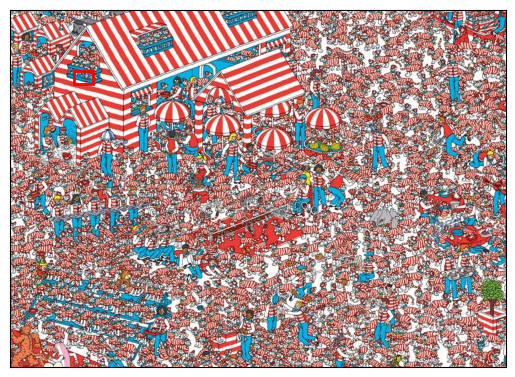

Predicted Bounding Box: [104.68346  89.30371 132.89012 108.54431]


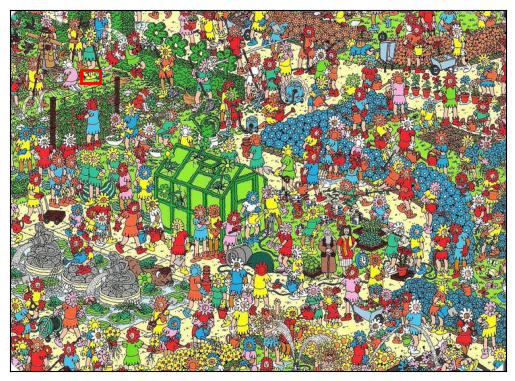

Predicted Bounding Box: [113.83613   92.379395 148.40305  115.99507 ]


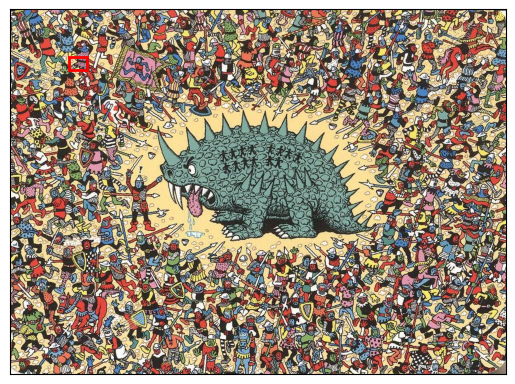

Predicted Bounding Box: [124.05553 137.16264 154.80402 169.9129 ]


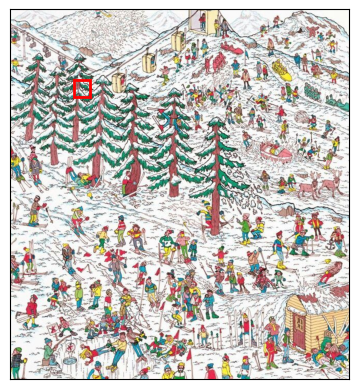

Predicted Bounding Box: [ 93.866394  79.80867  118.98738  104.37994 ]


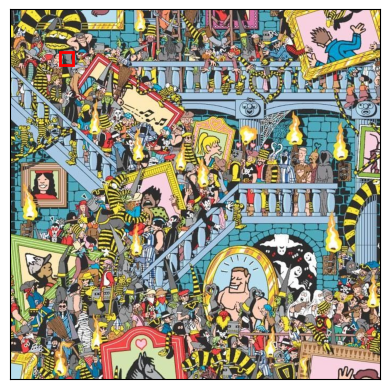

Predicted Bounding Box: [486.89233 296.1453  603.1161  369.61945]


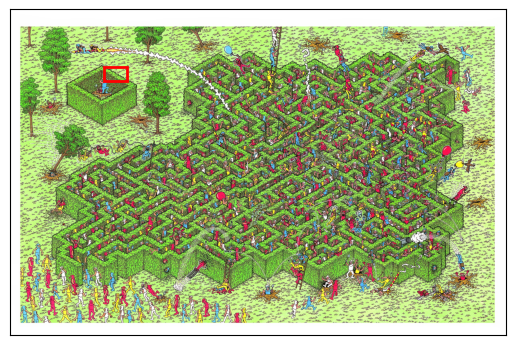

Predicted Bounding Box: [361.1581  244.3705  443.8053  296.06473]


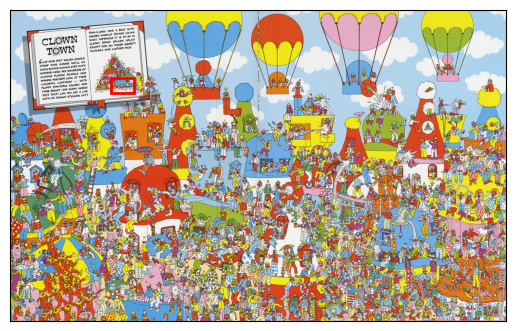

Predicted Bounding Box: [181.93207 130.2247  225.20175 158.21384]


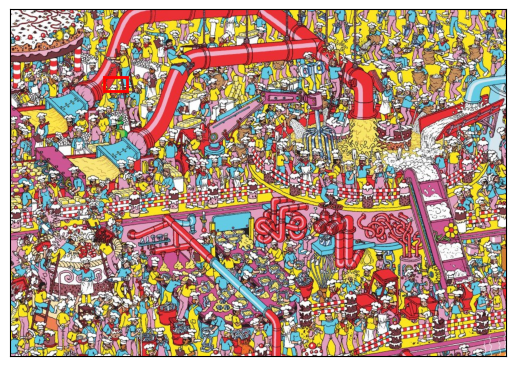

In [12]:
predictions = []

output_directory = "2024-fall-ml-3-hw-4-wheres-waldo/outputs"
if not os.path.exists(output_directory):
        os.makedirs(output_directory)

# Function to predict bounding box on a new image
def predict(model, image_path, transform=None):
    model.eval()  # Set the model to evaluation mode

    # Load and preprocess the image
    image = Image.open(image_path).convert("RGB")  # Open image and convert to RGB
    orig_width, orig_height = image.size  # Get original image dimensions
    if transform:
        image = transform(image)  # Apply transformations
    image = image.unsqueeze(0)  # Add batch dimension

    # Ensure image is a Tensor and move it to the correct device
    image = image.to(device)

    # Predict the bounding box
    with torch.no_grad():
        predicted_bbox = model(image).squeeze().cpu().numpy()

    # Scale bbox back to original image dimensions
    predicted_bbox[0] *= orig_width / image_sz  # x_min
    predicted_bbox[1] *= orig_height / image_sz  # y_min
    predicted_bbox[2] *= orig_width / image_sz  # x_max
    predicted_bbox[3] *= orig_height / image_sz  # y_max

    return predicted_bbox


# Define image transformations (resize, normalization)
transform = transforms.Compose([
    transforms.Resize((image_sz, image_sz)),  # Resize the image to 128x128
    transforms.ToTensor(),  # Convert the image to a tensor
    #torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

#For each image in test folder, predict, draw bounding box, save image, and save into csv file for submission
test_images = [img for img in os.listdir(test_folder) if img.endswith(".jpg")]
predictions = []

for name in test_images:
    # Example usage for prediction on a new image
    image_path = os.path.join(test_folder, name)  # Replace with the path to your test image
    predicted_bbox = predict(model, image_path, transform)

    # Print the predicted bounding box (x_min, y_min, x_max, y_max)
    print("Predicted Bounding Box:", predicted_bbox)

    # Plot the image and the predicted bounding box
    image = Image.open(image_path)
    plt.imshow(image)
    plt.gca().add_patch(plt.Rectangle(
        (predicted_bbox[0], predicted_bbox[1]),  # (x_min, y_min)
        predicted_bbox[2] - predicted_bbox[0],  # Width (x_max - x_min)
        predicted_bbox[3] - predicted_bbox[1],  # Height (y_max - y_min)
        linewidth=2, edgecolor='r', facecolor='none'
    ))
    plt.xticks([])
    plt.yticks([])
    plt.savefig(os.path.join(output_directory, name), bbox_inches='tight')
    plt.show()

    # Extract bounding box coordinates
    x_min, y_min, x_max, y_max = predicted_bbox
    predictions.append([name, x_min, y_min, x_max, y_max])

# Save predictions to CSV
df = pd.DataFrame(predictions, columns=["filename", "xmin", "ymin", "xmax", "ymax"])
df.to_csv(os.path.join(output_directory, 'predictions.csv'), index=False)
